# Clothing size predictor data and model's creation
Through this notebook, the dataset gathered from [this Kaggle post](https://www.kaggle.com/tourist55/clothessizeprediction) is analyzed and used for training a Pytorch nerual network which predicts the size that fits the best for a person according to his weight, age and height.

## Dependencies
Dependencies used and their job were:
* pandas: Used for data analysis and wrangling.
* numpy: Data treatment.
* matplotlib: Graphic analysis.
* sklearn: Train-Test split of the dataset and R2 metric.
* torch: Framework for the neural network's training process.
* time: Calculating training time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torchsummary import summary
import time
from sklearn.metrics import r2_score

## Data treatment and analysis

The "final_test.csv" dataset has weight, age, height and clothing size as columns, in which the first 3 were selected for training the model. Size column was converted to values from 0-6 as Strings cannot be outputed by a NN (Creating one-hot encoding | dummy variables for the size column could be another way to solve this problem). All weight, age and height datapoints were normalized from 0 to 1 according to the maximum and minimum values in each set of column values.

In [2]:
# READING DATA

data = pd.read_csv('final_test.csv')
print('The number of datapoints in the whole dataset is: ',data.shape[0])
print('The number of columns in the dataset is: ', data.shape[1])

# DATA PREVIEW

data.head()

Number of datapoints in the whole dataset are:  119734
Number of columns in the dataset are:  4


,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


### Comparison between Size (target) and all the indipendent variables

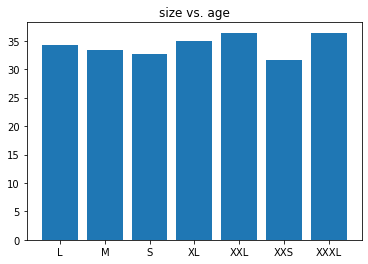

In [3]:
plt.bar(data.groupby('size').mean()['age'].index, data.groupby('size').mean()['age'].values)
plt.title('size vs. age');
plt.savefig('Size-Age.png', dpi=200, transparent=True, bbox_inches='tight')

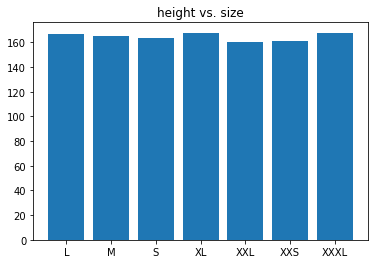

In [9]:
plt.bar(data.groupby('size').mean()['height'].index, data.groupby('size').mean()['height'].values)
plt.title('height vs. size');
plt.savefig('Size-Height.png', dpi=200, transparent=True, bbox_inches='tight')

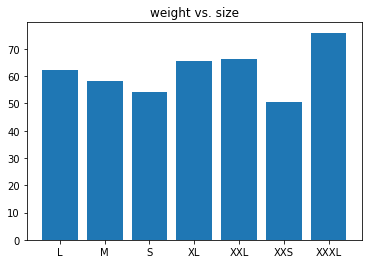

In [10]:
plt.bar(data.groupby('size').mean()['weight'].index, data.groupby('size').mean()['weight'].values)
plt.title('weight vs. size');
plt.savefig('Size-Weight.png', dpi=200, transparent=True, bbox_inches='tight')

From the data, we can get that there is a bias problem where the range of data is very restricted which can lead to a bad performance of the model, as the data is not varied.

### Correlation between variables in the dataset
Code extracted from [here](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

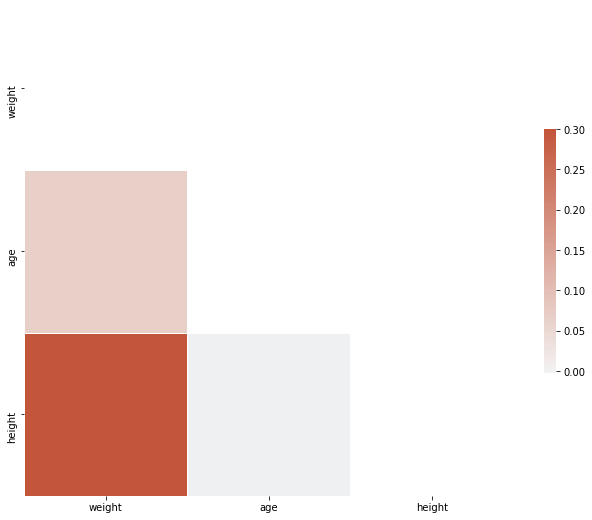

In [6]:

import seaborn as sns
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('Heatmap.png', dpi=200, transparent=True, bbox_inches='tight')



Here, we can see that age with height are not correlated at all and weight with age neither, however we can't discard this variable as it can lead us to better performance in the model as there are more characteristics to learn, thus the model would be more precise.

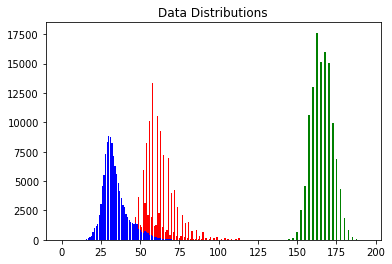

In [7]:
# PLOTTING DISTRIBUTION OF COLUMNS

plt.bar(data['weight'].value_counts().index, data['weight'].value_counts().values, color='r');
plt.bar(data['age'].value_counts().index, data['age'].value_counts().values, color='b');
plt.bar(data['height'].value_counts().index, data['height'].value_counts().values, color='g');
plt.title('Data Distributions');
plt.savefig('Data-Distributions.png', dpi=200, transparent=True, bbox_inches='tight')

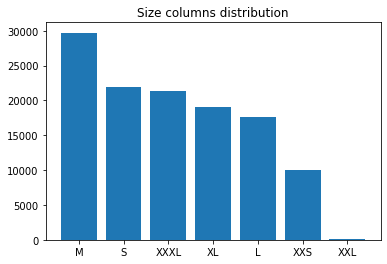

In [8]:
# SIZE COLUMN PLOTTED IN A DIFFERENT CELL AS IT CONTAINS STRING VALUES YET

plt.bar(data['size'].value_counts().index, data['size'].value_counts().values);
plt.title('Size columns distribution');
plt.savefig('Size-Distributions.png', dpi=200, transparent=True, bbox_inches='tight')

From these plots we can see that there is a clear normal distribution for the main 3 columns and a clear dominance in the "Medium" size for the last column.

In [11]:
# CHECKING DATA MEANS AND DATA TYPES

print('Average height in the dataset: ',data.height.mean())
print('Average age in the dataset: ',data.age.mean())
print('Average weight in the dataset: ',data.weight.mean())
print('dtype of Height: ', data.height.dtype)
print('dtype of Age: ', data.age.dtype)
print('dtype of Weight: ', data.weight.dtype)

Average height in the dataset:  165.8057942782486
Average age in the dataset:  34.027310695782454
Average weight in the dataset:  61.75681093089682
dtype of Height:  float64
dtype of Age:  float64
dtype of Weight:  int64


In [12]:
# FUNCTION TO TRANSLATE FROM STRING SIZE TO ENCODED FLOAT

def map_size(size):
    """
    Takes the clothing size as string type and returns the corresponding coded value in float type.
    """
    if size == 'XXS':
        return 0.0
    elif size == 'S':
        return 1.0
    elif size == 'M':
        return 2.0
    elif size == 'L':
        return 3.0
    elif size == 'XL':
        return 4.0
    elif size == 'XXL':
        return 5.0
    elif size == 'XXXL':
        return 6.0

In [13]:
# DROPPING ALL THE NaNs VALUES AS THERE ARE ENOUGH VALUES ALREADY.
# APPLYING THE MAPPING FUNCTION FOR THE SIZE COLUMN
# CASTING WEIGHT COLUMN DATATYPE TO FLOAT
# IGNORING ROWS WHERE THE AGE IS 0 AS THESE DATAPOINTS HAVE NO SENSE


data = data.dropna()
data['weight'] = data['weight'].astype('float64')
data['height'] = data['height'].apply(np.round)
data['size'] = data['size'].apply(map_size)
data = data[data['age'] != 0]

In [14]:
# APPLYING NORMALIZATION FOR EACH INPUT COLUMN

def NormalizeData01(data, min_, max_):
    return (data - min_) / (max_ - min_)
def NormalizeDataMinus1to1(data, min_, max_): # This funtion wasn't used as it didn't show better performance
    return (2*((data - min_) / (max_ - min_))) - 1

data['weight'] = data['weight'].apply(lambda x: NormalizeData01(x, data['weight'].min(), data['weight'].max()))     
data['age'] = data['age'].apply(lambda x: NormalizeData01(x, data['age'].min(), data['age'].max()))      
data['height'] = data['height'].apply(lambda x: NormalizeData01(x, data['height'].min(), data['height'].max()))     

## Model's creation
Using Pytorch (Facebook's ML framework), a neural network is created for predicting clothing size. Hyperparameters used were:
* Learning Rate: 0.01
* Optimizer: SGD with momentum
* Number of epochs: 50
* Activation funtions: Relu
* Number of hidden layers: 2
* Number of neurons per hidden layer: 64
* Loss function (Main metric): CrossEntropyLoss (used for classification problems)
* Accuracy metric: R2 Score
* Train-Validation-Test split: 60|20|20
* Validation every 5 batches of training.

In [15]:
X = data[['weight', 'age', 'height']]
Y = data['size']
X = X.values
Y = Y.values

# DATASET 60-20-20 SPLIT PROPORTION TRAIN-VALIDATE-TEST RESPECTIVELY

X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.4)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5)

In [16]:
# CONVERTING DATA TO TENSORS

X_train = torch.from_numpy(X_train).type(torch.FloatTensor)

X_val = torch.from_numpy(X_val).type(torch.FloatTensor)

X_test = torch.from_numpy(X_test).type(torch.FloatTensor)

Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)

Y_val = torch.from_numpy(Y_val).type(torch.FloatTensor)

# SETTING TENSOR DATASETS

train_tensor = torch.utils.data.TensorDataset(X_train, Y_train)

validation_tensor = torch.utils.data.TensorDataset(X_val, Y_val)

test_tensor = torch.utils.data.TensorDataset(X_test)

# FINAL DATA LOADERS - SETTING BATCH CONFIGURATION

train_loader = torch.utils.data.DataLoader(train_tensor,
                                           batch_size=64,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_tensor,
                                                batch_size=64,
                                                shuffle=False)

test_loader = torch.utils.data.DataLoader(test_tensor,
                                          batch_size=64,
                                          shuffle=False)


In [17]:
# MODEL SET-UP

input_size = 3
hidden_sizes = [64, 64]
output_size = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      )

In [18]:
# XAVIER'S WEIGHTS INITIALIZATION

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight, gain=1.0)

In [19]:
# PRE-TRAINING SET-UP

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 50
criterion = nn.CrossEntropyLoss()
model.to(device)
running_loss = 0
steps = 0
best_model_r2 = 0

In [20]:
# TRAINING START

print('Training Started!')
start = time.time()
for e in range(epochs):
    print('Epoch number: ', e + 1)

    for inputs, labels in train_loader:

        # TRAINING LOOP

        inputs, labels = inputs.float(), labels.float()
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        steps += 1

        # 5 VALIDATION LOOPS PER EPOCH
        
        if steps == int(len(train_loader) / 5):
            sanity = []
            model.eval()
            accuracy = 0
            valid_loss = 0

            with torch.no_grad():

                for inputs, labels in validation_loader:

                    # VALIDATION LOOP

                    inputs, labels = inputs.float(), labels.float()
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)

                    loss_valid = criterion(outputs, labels.long())
                    valid_loss += loss_valid.item()
                    
                    labels = labels.cpu()
                    outputs = outputs.cpu()
                    _, outputs = torch.max(outputs.data, 1)
                    
                    accuracy += r2_score(labels, outputs)
                    
                overall_accuracy = (accuracy * 100) / len(validation_loader)
                
                # If the overall accuracy is better than the best one we've got, save the model
                if overall_accuracy > best_model_r2: 
                    best_model_r2 = overall_accuracy
                    torch.save(model, 'clothing_size.pth')
                print(
                    f"Train loss: {running_loss / steps:.4f}.. "
                    f"Valid loss: {valid_loss / len(validation_loader):.4f}.. "
                    f"Valid accuracy: {(accuracy * 100) / len(validation_loader):.5f}..")

            running_loss = 0
            steps = 0
            model.train()

print('Training finished!')
print('Training lasted: ', time.time() - start)


Training Started!
Epoch number:  1
Train loss: 1.7630.. Valid loss: 1.7033.. Valid accuracy: -5.61905..
Train loss: 1.5863.. Valid loss: 1.4339.. Valid accuracy: 38.66745..
Train loss: 1.3166.. Valid loss: 1.2182.. Valid accuracy: 61.04423..
Train loss: 1.2010.. Valid loss: 1.1637.. Valid accuracy: 64.71895..
Train loss: 1.1725.. Valid loss: 1.1533.. Valid accuracy: 62.04616..
Epoch number:  2
Train loss: 1.1549.. Valid loss: 1.1425.. Valid accuracy: 65.49643..
Train loss: 1.1618.. Valid loss: 1.1387.. Valid accuracy: 64.26032..
Train loss: 1.1593.. Valid loss: 1.1497.. Valid accuracy: 62.09812..
Train loss: 1.1627.. Valid loss: 1.1521.. Valid accuracy: 62.49048..
Train loss: 1.1523.. Valid loss: 1.1361.. Valid accuracy: 66.56463..
Epoch number:  3
Train loss: 1.1650.. Valid loss: 1.1370.. Valid accuracy: 64.74831..
Train loss: 1.1631.. Valid loss: 1.1341.. Valid accuracy: 64.49221..
Train loss: 1.1536.. Valid loss: 1.1359.. Valid accuracy: 62.27648..
Train loss: 1.1412.. Valid loss: 1

Train loss: 1.1246.. Valid loss: 1.1246.. Valid accuracy: 63.83942..
Train loss: 1.1317.. Valid loss: 1.1353.. Valid accuracy: 65.44788..
Epoch number:  24
Train loss: 1.1290.. Valid loss: 1.1255.. Valid accuracy: 66.10230..
Train loss: 1.1345.. Valid loss: 1.1240.. Valid accuracy: 66.01425..
Train loss: 1.1335.. Valid loss: 1.1225.. Valid accuracy: 66.75495..
Train loss: 1.1364.. Valid loss: 1.1253.. Valid accuracy: 64.99446..
Train loss: 1.1290.. Valid loss: 1.1232.. Valid accuracy: 64.10650..
Epoch number:  25
Train loss: 1.1321.. Valid loss: 1.1263.. Valid accuracy: 65.71588..
Train loss: 1.1361.. Valid loss: 1.1465.. Valid accuracy: 64.25245..
Train loss: 1.1310.. Valid loss: 1.1284.. Valid accuracy: 64.24730..
Train loss: 1.1289.. Valid loss: 1.1241.. Valid accuracy: 65.61470..
Train loss: 1.1296.. Valid loss: 1.1215.. Valid accuracy: 65.89984..
Epoch number:  26
Train loss: 1.1411.. Valid loss: 1.1260.. Valid accuracy: 65.81658..
Train loss: 1.1269.. Valid loss: 1.1219.. Valid a

Train loss: 1.1309.. Valid loss: 1.1227.. Valid accuracy: 63.55582..
Train loss: 1.1241.. Valid loss: 1.1213.. Valid accuracy: 66.05168..
Train loss: 1.1301.. Valid loss: 1.1222.. Valid accuracy: 66.06541..
Train loss: 1.1208.. Valid loss: 1.1215.. Valid accuracy: 66.03915..
Epoch number:  47
Train loss: 1.1340.. Valid loss: 1.1202.. Valid accuracy: 67.28172..
Train loss: 1.1382.. Valid loss: 1.1220.. Valid accuracy: 64.41184..
Train loss: 1.1378.. Valid loss: 1.1239.. Valid accuracy: 66.92048..
Train loss: 1.1152.. Valid loss: 1.1199.. Valid accuracy: 66.58513..
Train loss: 1.1259.. Valid loss: 1.1219.. Valid accuracy: 66.41862..
Epoch number:  48
Train loss: 1.1255.. Valid loss: 1.1204.. Valid accuracy: 66.10554..
Train loss: 1.1329.. Valid loss: 1.1395.. Valid accuracy: 65.21634..
Train loss: 1.1290.. Valid loss: 1.1185.. Valid accuracy: 65.62222..
Train loss: 1.1243.. Valid loss: 1.1205.. Valid accuracy: 66.78469..
Train loss: 1.1286.. Valid loss: 1.1240.. Valid accuracy: 64.68122.

In [21]:
# PRINT MODEL'S CHARACTERISTICS

summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            256
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            455
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            256
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            455
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0

## Conclusions
From the training results we can see that the model didn't perform well because of the factors mentioned before:
* Variety in data is poor.
* Correlation between data is low.

For this problem, having more variety of data-points (e.g more height values from kids or ancient people | Having more weight values from kids and overweighted people) would help a lot without thinking about adding the number of variables which would make the model even 2x better however it makes the model and the input values more complex too. Even though the model had an R2 score of 0.6772 (67.72%) on a general basis the model performs decently in the app.